$\color{Green}{\text{Note: this notebook might take some time to run.}}$

### Essential imports

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost

from utils.HiggsBosonCompetition_AMSMetric_rev1 import AMS_metric

### Load the data

In [2]:
data = pd.read_csv("dataset/atlas-higgs-challenge-2014-v2.csv", delimiter=",")

In [3]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


### Clean and transform the data

Impute missing values with mean (this is the simple option which doesn't affect the results too badly).  
Scale the dataset, change `y` labels to 1 and 0 and split the data according to the original Kaggle set.

In [49]:
X, y = (
    data.iloc[:, 1:-4].drop(columns=["PRI_jet_leading_phi", "PRI_jet_subleading_phi"]).values,
    data["Label"].values
)

In [50]:
pipeline = Pipeline([
        ('mean_imputer', SimpleImputer(missing_values=-999.0, strategy='mean')),
        ('std_scaler', StandardScaler())
])
X_transformed = pipeline.fit_transform(X)
y = np.array(list(map(lambda a: 1 if a == 's' else 0, y)))

In [51]:
X_train = X_transformed[data["KaggleSet"] == 't']
X_test = X_transformed[data["KaggleSet"].isin(('v', 'b'))]  
y_train = y[data["KaggleSet"] == 't']
y_test = y[data["KaggleSet"].isin(('v', 'b'))]
weights = data["KaggleWeight"].to_numpy()
weights_train = weights[data["KaggleSet"] == 't']
weights_test = weights[data["KaggleSet"].isin(('v', 'b'))]

### Model exploration

$\color{Green}{\text{Some essential functions}}$

In [197]:
# The model has to be able to predict probabilities
def predict_with_threshold(x, model, threshold):
    prediction = (model.predict_proba(x)[:, 1] >= threshold).astype(int)
    return prediction

# This is an inaccurate AMS estimate using the official function, also saves the file for Kaggle submission
# Its only use is to see the behavior of AMS, not its value.
def estimated_ams_score(model, threshold):
    submission = pd.DataFrame({
        'EventId': data[data["KaggleSet"].isin(('v', 'b'))]["EventId"],
        'RankOrder': model.predict_proba(X_test)[:, 1].argsort() + 1,
        'Class': list(map(lambda a: 's' if a == 1 else 'b', predict_with_threshold(X_test, model, threshold)))
    }).to_csv('submission.csv', index=False)
    return AMS_metric('test.csv', 'submission.csv')

def plot_estimated_ams(model):
    plt.figure()
    T, AMS = [], []
    for t in np.linspace(0.0, 1.0, 20):
        T.append(t)
        AMS.append(ams_score_function(y_train, weights_train, predict_with_threshold(X_train, model, t)))
        plt.plot(T, AMS, '--r')
        plt.grid(True)
        plt.xlabel('threshold')
        plt.ylabel('AMS')

$\color{Green}{\text{Logistic regression}}$

In [173]:
logistic_param_grid = [
    {'C': [0.1, 0.3, 1.0, 3.0, 10.0]},
]
logistic_grid_search = GridSearchCV(linear_model.LogisticRegression(solver='lbfgs'),
                           logistic_param_grid, cv=5, scoring='f1')
logistic_grid_search.fit(X_train, y_train)
logistic_grid_search.cv_results_["mean_test_score"]

array([0.59522827, 0.59531723, 0.59534342, 0.59534884, 0.59538526])

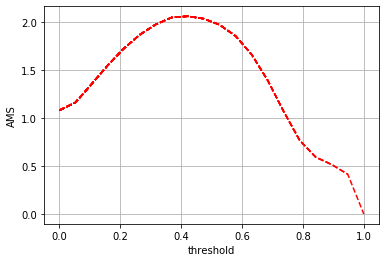

In [198]:
plot_estimated_ams(logistic_grid_search.best_estimator_)

Logistic regression shows poor performance.

$\color{Green}{\text{Random forest}}$

In [196]:
rnd_grid = {'bootstrap': [True, False],
            'max_depth': [3, 5, 10, 15, None],
            'max_features': ['auto', None],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [50, 100, 300, 500]}

rnd_grid_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=111, n_jobs=-1), 
    param_distributions = rnd_grid,
    n_iter = 10,
    cv = 3,
    random_state=111,
    n_jobs = -1,
    scoring='f1'
)
rnd_grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1, 

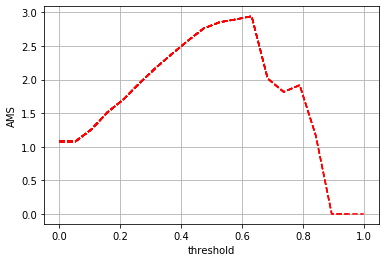

In [200]:
plot_estimated_ams(rnd_grid_search.best_estimator_)

Random forests are much better, but XGBoost may be good too.

$\color{Green}{\text{XGBoost}}$

In [ ]:
xgb_grid = {'learning_rate': [0.1],
            'max_depth': [3, 5, 10, 15],
            'max_features': ['auto', None],
            'colsample_bytree': [0.3, 0.5, 0.8, 1],
            'n_estimators': [50, 100, 300]}

xgb_grid_search = RandomizedSearchCV(
    xgboost.XGBClassifier(), 
    param_distributions = rnd_grid,
    n_iter = 10,
    cv = 3,
    random_state=111,
    scoring='f1'
)
xgb_grid_search.fit(X_train, y_train)

In [44]:
model = xgboost.XGBClassifier(max_depth=10, n_estimators=120, learning_rate=0.1, n_jobs=-1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

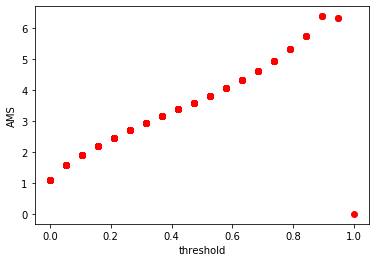

In [190]:
plot_estimated_ams(model)

### Save the result to evaluate AMS score

In [136]:
submission = pd.DataFrame({
    'EventId': data[data["KaggleSet"].isin(('v', 'b'))]["EventId"],
    'RankOrder': model.predict_proba(X_test)[:, 1].argsort() + 1,
    'Class': list(map(lambda a: 's' if a == 1 else 'b', predict_with_threshold(X_test, model, 0.8)))
})

In [ ]:
submission.to_csv('submission.csv', index=False)